# TRABAJO TEMA 10 - Agente de Ofertas - Diego Garda Porto

In [1]:
# 1- Instalación de dependencias (Ejecutar siempre al iniciar Colab)
%pip install langchain langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 3.2 MB/s eta 0:00:00


Configuración del entorno

In [2]:
# 2- Configuración de Entorno
import os
from google.colab import userdata
from langchain_openai import ChatOpenAI

try:
    # 1- Lectura de la clave de OpenAI
    clave = userdata.get('OPENIA_API_KEY')

    # 2- La traducimos a inglés porque yo la puse como OPENIA en lugar de OPENAI
    os.environ["OPENAI_API_KEY"] = clave

    print("API de OpenAI cargada correctamente")

except Exception as e:
    print(f"ERROR: {e}")

# Inicialización del Modelo
modelo = ChatOpenAI(model="gpt-4o-mini", temperature=0)

API de OpenAI cargada correctamente


Definición del Estado del Agente

In [3]:
# 3- Definición del Estado del Agente
from typing import TypedDict, Optional

class AgentState(TypedDict):
    """Estado del grafo"""
    descripcion_empleo: str    # Input: Oferta
    perfil_usuario: str       # Input: Candidato
    puntuacion: int        # Output Analista
    feedback: str           # Output Analista
    carta_presentacion: Optional[str] # Output Editor
    final_decision: str     # Estado final

NODO ANALISTA:

Nodo encargado de realizar la evaluación de la oferta, leer el perfil del usuario y calcular la relación entre ambos (puntuación)

In [4]:
# 4- Nodo Analista
from langchain_core.messages import SystemMessage, HumanMessage
import json

def nodo_analista(state: AgentState):
    print("NODO ANALISTA: Evaluando oferta...")

    # 1- Entrada
    empleo = state.get("descripcion_empleo", "")
    perfil = state.get("perfil_usuario", "")

    # 2- Proceso
    mensaje_sys = SystemMessage(content="""
        Eres un reclutador experto de talento. Tu trabajo es analizar si un candidato encaja en una oferta.

        Debes responder ÚNICAMENTE con un JSON válido que tenga esta estructura exacta (sin acentos en las claves):
        {
            "puntuacion": (número entero del 0 al 100),
            "feedback": "(breve explicación de la nota y justificación de esta)"
        }

        CRITERIOS:
        - Sé crítico. Si faltan requisitos clave, la puntuación debe ser baja (<50).
        - Valora positivamente cursos y formaciones.
        - Valora positivamente experiencia profesional, aunque da prioridad a la específica.
    """)

    mensaje_usuario = HumanMessage(content=f"""
        OFERTA DE TRABAJO:
        {empleo}

        PERFIL DEL CANDIDATO:
        {perfil}
    """)

    # Invocación del modelo
    response = modelo.invoke([mensaje_sys, mensaje_usuario])

    # 3- Salida mediante JSON
    try:
        # Limpieza
        content = response.content.strip().replace("```json", "").replace("```", "")
        data = json.loads(content)

        # Extracción de los datos principales
        puntuacion_final = data.get("puntuacion", 0)
        feedback_final = data.get("feedback", "No se pudo generar feedback")

    except Exception as e:
        print(f" Error al leer el JSON: {e}")
        puntuacion_final = 0
        feedback_final = "Error de formato en la respuesta del LLM"

    print(f"   Puntuación: {puntuacion_final}/100")
    print(f"   Feedback: {feedback_final}")

    # 4- Actualización. Retorno de los datos
    return {
        "puntuacion": puntuacion_final,
        "feedback": feedback_final
    }

NODO EDITOR

Nodo que actúa solo si la oferta es adecuada para el solicitante.
Si esto se cumple, el modelo crea una carta.

In [5]:
# 5- Nodo Editor (Redactor de la carta)
def nodo_editor(state: AgentState):
    print("NODO EDITOR: Redactando carta...")

    # 1- Recuperar los datos
    empleo = state.get("descripcion_empleo", "")
    perfil = state.get("perfil_usuario", "")

    # 2- Definir el Prompt para redactar
    mensaje_sys = SystemMessage(content="""
        Eres un experto redactor de cartas de presentación.
        Tu objetivo es escribir una carta profesional, persuasiva y breve.

        INSTRUCCIONES:
        - Usa un tono formal.
        - No te inventes información que no se encuentre en el perfil del solicitante.
        - Destaca cómo el perfil del candidato cumple con las necesidades de la oferta y por qué es una opción adecuada.
        - Crea una carta de presentacion redactada en lenguaje humano (sin corchetes, variables...), que sea texto formal listo para enviarse al destinatario (empleador)
        - No recogas las variables y las muestres como nombre, correo electrónico, destinatario..., simplemente redacta un texto de presentación breve en primera persona. Ej: Soy ... graduado en ...
          completando dicha con la información del usuario que solicita.
    """)

    mensaje_usuario = HumanMessage(content=f"""
        Esta es la oferta:
        {empleo}

        Este es mi perfil:
        {perfil}

        Por favor, escribe la carta de presentación.
    """)

    # 3- Invocar al modelo
    respuesta = modelo.invoke([mensaje_sys, mensaje_usuario])

    # 4. Obtener el texto
    carta = respuesta.content

    print("Carta generada con éxito.")

    # 5- Devolver la actualización del estado
    return {
        "carta_presentacion": carta
    }

FUNCIÓN DE DECISIÓN

Función que obtiene la información de la nota y toma una decisión a partir de este valor. Si el candidato a apribado (nota igual o superior a 5) se selecciona como posible candidato y se realiza la redacción de la carta. En caso contrario se descarta dicho candidato.

In [6]:
# 6- Función de Decisión
def decidir_camino(state: AgentState):
    """
    Esta función revisa la puntuación y decide el siguiente paso.
    Devuelve el NOMBRE del nodo al que queremos ir.
    """
    puntuacion = state.get("puntuacion", 0)

    print(f"DECISIÓN: La nota es {puntuacion}")

    # Lógica de la decisión
    if puntuacion >= 50:
        print("   Decisión: APROBADO - Vamos a redactar carta.")
        return "redactar_carta"  # Devolveremos este string para guiar al grafo
    else:
        print("   Decisión: SUSPENSO - Fin del proceso.")
        return "descartar"       # Devolveremos este string para terminar

CONSTRUCCIÓN DEL GRAFO

En este grafo es donde se va a controlar todo el flujo del programa, decidiendo que pasos ejecutar según los strings que se devuelvan en cada caso. Estas cadena de caracteres son las que guían al gráfo para ir por un camino o por otro. Cada nodo funciona como una "estación de trabajo" realizando determinadas acciones en cada uno de estos nodos y pasando al siguiente en función de los resultados obtenidos en estos nodos.

In [7]:
# 7- Construcción del Grafo (Graph Construction)
from langgraph.graph import StateGraph, END

# 1- Inicialización del grafo con nuestro estado
workflow = StateGraph(AgentState)

# 2- Añadir los nodos creados anteriormente
workflow.add_node("analista", nodo_analista)
workflow.add_node("editor", nodo_editor)

# 3- Definir el punto de entrada
# El grafo siempre empieza por el Analista
workflow.set_entry_point("analista")

# 4- Añadir la lógica condicional (la toma de decisiones)
# Desde el "analista", ejecutar la función "decidir_camino"
workflow.add_conditional_edges(
    "analista",           # Desde dónde salimos
    decidir_camino,       # Qué función decide
    {
        "redactar_carta": "editor",
        "descartar": END
    }
)

# 5- Cerrar el camino del Editor
# Después de escribir la carta, siempre vamos al final
workflow.add_edge("editor", END)

# 6- Compilar el grafo para convertirlo en una "app" ejecutable
app = workflow.compile()

print("Grafo construido y compilado correctamente.")

Grafo construido y compilado correctamente.


VISUALIZACIÓN DEL GRAFO

In [8]:
# Instalación de las herramientas necesarias para generar el grafo
%pip install grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.9 MB/s eta 0:00:00


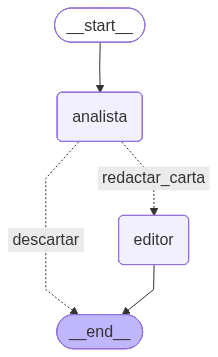

Diagrama generado correctamente.


In [9]:
# 8- Visualización del Grafo
from IPython.display import Image, display

try:
    # Generación de la imagen del flujo usando Mermaid
    display(Image(app.get_graph().draw_mermaid_png()))
    print("Diagrama generado correctamente.")
except Exception as e:
    print(f"No se pudo generar la imagen automáticamente: {e}")
    print("Prueba instalando: %pip install grandalf")

PRUEBAS Y VALIDACIÓN

Ejecución de un par de casos, uno que tiene que ser admitido por las coincidencias entre el puesto y el usuario y otro que va ser rechazado.

In [10]:
# 9- Pruebas de Ejecución (Testing)

# Definición de un perfil de candidato
mi_perfil = """
Diego Garda Porto, 616149560, correoejemplo@gmail.com
Ingeniero Informático recién graduado.
Experiencia en Python, Data Science y desarrollo Backend con Django.
He realizado prácticas curriculares gestionando bases de datos SQL.
Nivel de inglés B2. Interés en Inteligencia Artificial.
"""

# ESCENARIO 1: LA OFERTA PERFECTA
oferta_buena = """
Buscamos Junior Python Developer para empresa de IA.
Requisitos: Conocimientos de Python, SQL y ganas de aprender.
Valorable: Inglés intermedio y experiencia con frameworks web.
"""

print("\nINICIANDO PRUEBA 1 (Oferta Compatible)")
resultado_1 = app.invoke({
    "descripcion_empleo": oferta_buena,
    "perfil_usuario": mi_perfil
})

print(f"RESULTADO 1:")
print(f"Nota: {resultado_1['puntuacion']}/100")
print(f"Carta de presentación generada: {resultado_1.get('carta_presentacion', 'Descartado')[:150]}...") # Mostrar el inicio de la carta


# ESCENARIO 2: LA OFERTA IMPOSIBLE
oferta_mala = """
Se busca Chef con 10 años de experiencia en cocina japonesa.
Imprescindible saber preparar piezas de shushi y disponer de un certificado de manipulación de alimentos.
Turno de noche.
"""
print("\n################################################################################")
print("\nINICIANDO PRUEBA 2 (Oferta Incompatible)")
resultado_2 = app.invoke({
    "descripcion_empleo": oferta_mala,
    "perfil_usuario": mi_perfil
})

print(f"RESULTADO 2:")
print(f"Nota: {resultado_2['puntuacion']}/100")

# Aquí la carta debería ser None o no existir
print(f"Carta de presentación generada: {resultado_2.get('carta_presentacion')}")


INICIANDO PRUEBA 1 (Oferta Compatible)
NODO ANALISTA: Evaluando oferta...
   Puntuación: 85/100
   Feedback: El candidato cumple con los requisitos básicos de conocimientos en Python y SQL, además de tener experiencia relevante en desarrollo Backend con Django, lo cual es un plus. Su nivel de inglés B2 es valorable y su interés en Inteligencia Artificial se alinea con la oferta. Sin embargo, no se menciona experiencia específica con frameworks web más allá de Django, lo que impide una puntuación más alta.
DECISIÓN: La nota es 85
   Decisión: APROBADO - Vamos a redactar carta.
NODO EDITOR: Redactando carta...
Carta generada con éxito.
RESULTADO 1:
Nota: 85/100
Carta de presentación generada: Estimados miembros del equipo de selección,

Me dirijo a ustedes con el interés de postularme para el puesto de Junior Python Developer en su empresa ...

################################################################################

INICIANDO PRUEBA 2 (Oferta Incompatible)
NODO ANALISTA: Evalua